In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

width = 12
height = 7
plt.rcParams["figure.figsize"] = (width, height)


from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import tflscripts
import json
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [2]:
test_set = tflscripts.TestSet(name='single_activity_models')
results = test_set.get_results()

In [3]:
len(results)

20480

In [10]:
configuration = tflscripts.read_configuration()

class TestResultStatistics:
    def __init__(self, result):
        self.result = result

    def accuracy(self):
        return accuracy_score(self.result.actual, self.result.predicted)

    def accuracy_negative(self):
        negative_actual = self.result.actual[self.result.actual == -1]
        negative_predicted = self.result.predicted[self.result.actual == -1]
        return accuracy_score(negative_actual, negative_predicted)

    def accuracy_positive(self):
        positive_actual = self.result.actual[self.result.actual != -1]
        positive_predicted = self.result.predicted[self.result.actual != -1]
        return accuracy_score(positive_actual, positive_predicted)

    def all_activities(self):
        labels = np.unique(self.result.actual_with_all_labels)
        return [configuration['activities'][l] for l in labels]

    def source_device_name(self):
        result = self.result
        return configuration['device_roles'][result.source_dataset][result.source_device]

    def target_device_name(self):
        result = self.result
        return configuration['device_roles'][result.target_dataset][result.target_device]

    def source_room(self):
        return self.result.source_dataset.split('-')[0]

    def target_room(self):
        return self.result.target_dataset.split('-')[0]
    
    def source_placement(self):
        return self.source_device_name().split(' ')[2]

    def target_placement(self):
        return self.target_device_name().split(' ')[2]

    def source_device(self):
        return ' '.join(self.source_device_name().split(' ')[0:2])

    def target_device(self):
        return ' '.join(self.target_device_name().split(' ')[0:2])

    def type_of_transfer(self):
        result = self.result
        if self.source_room() != self.target_room():
            return 'Across spaces'

        source_device_split = self.source_device_name().split(' ')
        target_device_split = self.target_device_name().split(' ')

        if self.source_device_name() == self.target_device_name():
            return 'Replica within spaces'
        if source_device_split[2] == target_device_split[2] and \
            source_device_split[0] == target_device_split[0]:
            return 'Same device type in same place'
        if source_device_split[2] == target_device_split[2]:
            return 'Different device in same place'
        if source_device_split[1] == target_device_split[1] and \
            source_device_split[0] == target_device_split[0]:
            return 'Same device in different place'
        if source_device_split[0] == target_device_split[0]:
            return 'Same device type in different place'
        return 'Different device in different place'

In [32]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree

def to_features(result):
    stat = TestResultStatistics(result)
    return {
        'features': result.features,
        'label': result.label,
        'classifier': result.classifier,
        'type_of_transfer': stat.type_of_transfer(),
        'source_room': stat.source_room(),
        'target_room': stat.target_room(),
        'source_device': stat.source_device(),
        'target_device': stat.target_device(),
        'source_placement': stat.source_placement(),
        'target_placement': stat.target_placement(),
        'accuracy_negative': round(stat.accuracy_negative(), 2)
    }

def to_label(result):
    stat = TestResultStatistics(result)
    bins = [
        [0.0, 0.25],
        [0.25, 0.5],
        [0.5, 0.75],
        [0.75, 1.0]
    ]
    acc = TestResultStatistics(result).accuracy_positive()
    return [i for i, b in enumerate(bins) if b[0] <= acc and b[1] >= acc][0]

filtered = [r for r in results if TestResultStatistics(r).accuracy_negative() >= 0.95]
filtered = [r for r in filtered if TestResultStatistics(r).type_of_transfer() != 'Across spaces']
X = [to_features(r) for r in filtered]
y = [to_label(r) for r in filtered]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

ppl = Pipeline([
    ('vect', DictVectorizer()),
    ('impute', Imputer()),
    ('clf', tree.DecisionTreeClassifier())
])

ppl.fit(X_train, y_train)
predicted = ppl.predict(X_test)
accuracy_score(y_test, predicted)

0.79778393351800558

In [9]:
from IPython.display import Image
import pydotplus

clf = ppl.named_steps['clf']

dot_data = tree.export_graphviz(clf, out_file=None,
#                                 feature_names=iris.feature_names,
#                                 class_names=iris.target_names,
                                filled=True, rounded=True,
                                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf("decision_tree.pdf")

True

In [55]:
errors = np.abs((y_test - predicted) / 10)
errors.mean(), errors.std()

(0.04583333333333333, 0.083229101480992398)

actual,0,1,2,3
predicted,,,,
0,920,55,17,7
1,64,64,20,10
2,26,13,36,25
3,14,8,18,147


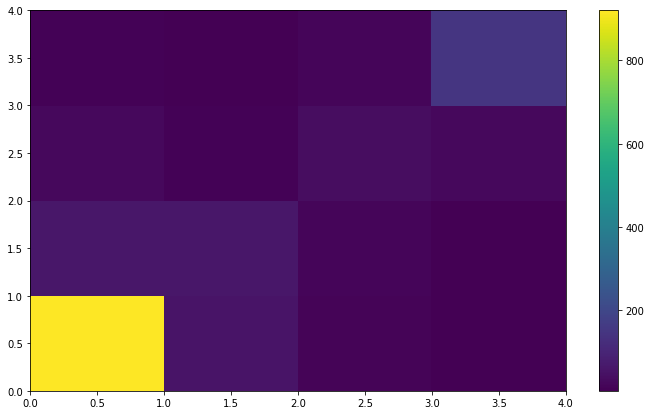

In [29]:
df = pd.DataFrame({'predicted': predicted, 'actual': y_test})
pivoted = df.pivot_table(index='predicted', columns='actual', aggfunc=len, fill_value=0)
plt.pcolor(pivoted)
plt.colorbar()
pivoted

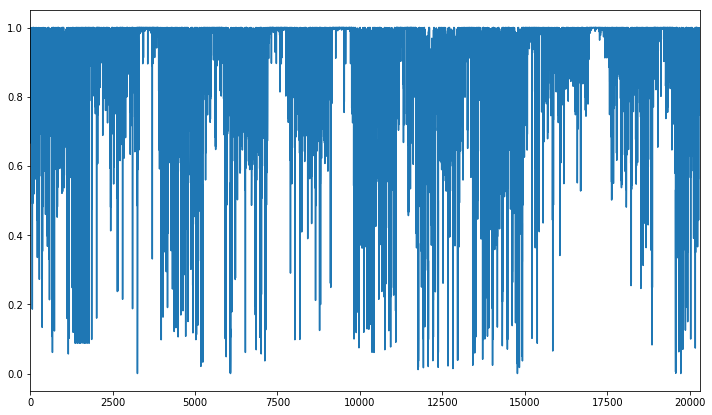

In [28]:
pd.Series([TestResultStatistics(r).accuracy_negative() for r in results]).plot()